In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 8.4MB/s 
     |████████████████████████████████| 9.5MB 10.7MB/s 
     |████████████████████████████████| 2.1MB 52.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [ ]:
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from pandas import datetime
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 427_days.csv to 427_days.csv


In [ ]:
data = pd.read_csv('427_days.csv',sep='\t')
data['DOS,']=data['DOS,'].replace({',':''},regex=True)
data['DOS,']= pd.to_datetime(data['DOS,'])
data.set_index("DOS,", inplace = True)
test=data[0:300]
train=data[300:]
print(train.tail())


            Message Count
DOS,                     
2019-10-29           2122
2019-10-30           2137
2019-10-31           1703
2019-11-01           1677
2019-11-02             37


In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(test, start_p=1, start_q=1,
                         test='adf',
                         max_p=1, max_q=1, m=52,
                         start_P=0, seasonal=True,
                         d=0, D=0, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=4804.726, Time=1.99 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=4877.881, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=4818.553, Time=2.89 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=4799.213, Time=6.01 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=5200.496, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=4801.263, Time=0.19 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=4801.937, Time=2.70 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=4792.058, Time=17.33 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=4795.061, Time=9.18 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=inf, Time=14.86 sec
 ARIMA(1,0,1)(0,0,2)[52] intercept   : AIC=4792.448, Time=36.78 sec
 ARIMA(1,0,0)(0,0,2)[52] intercept   : AIC=4809.535, Time=17.96 sec
 ARIMA(0,0,1)(0,0,2)[52]             : AIC=inf, Time=16.98 sec

Best model:  ARIMA(0,0,1)(0,0,2)[52] intercept
Total fit time: 127.101 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  300
Model:             SARIMAX(0, 0, 1)x(0, 0, [1, 2], 52)   Log Likelihood               -2391.029
Date:                                 Mon, 15 Mar 2021   AIC                           4792.058
Time:                                         07:13:37   BIC                           4810.577
Sample:                                              0   HQIC                          4799.469
                                                 - 300                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1064.4427     78.395     13.578      0.000     910.791    1218.094
ma.L1          0.5119      0.054      9.428      0.000       0.405       0.618
ma.S.L52      -0.0494      0.061     -0.806      0.420      -0.170       0.071
ma.S.L104      0.3093      0.086      3.609      0.000       0.141       0.477
sigma2      4.607e+05   4.71e+04      9.784      0.000    3.68e+05    5.53e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.21
Prob(Q):                              0.91   Prob(JB):                         0.03
Heteroskedasticity (H):               2.86   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Forecast
n_periods = 127
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(test.index[-1], periods = n_periods, freq='D')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)


In [ ]:
print(fitted.shape)


(127,)


In [ ]:
mae = mean_absolute_error(fitted, train)
print('mae :',mae)

mae : 860.6182741466547


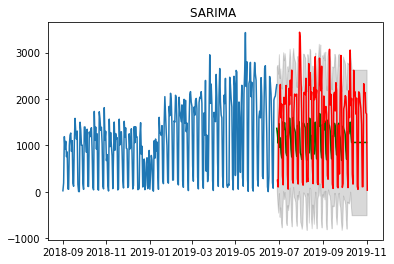

In [ ]:
# Plot
plt.plot(test)
plt.plot(fitted_series, color='darkgreen')
plt.plot(train,color='red')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)

plt.title("SARIMA ")
plt.show()